# Demo of Ev3DevSim in a Jupyter Notebook


Experiments trying to get [`ev3devsim`](https://www.aposteriori.com.sg/Ev3devSim/index.html) [[code](https://github.com/QuirkyCort/ev3dev-sim)] running in a Jupyter notebook as  [`jp_proxy_widget`](https://github.com/AaronWatters/jp_proxy_widget/blob/master/notebooks/Tutorial.ipynb) proxied `ipywidget`.

In [33]:
%load_ext autoreload
%autoreload 2
    
import ev3devsim_nb as eds
#from nbev3devsim import ev3devsim_nb as eds2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The model I'm working towards is:

- code is entered into a block magic code cell and sent to the simulator;
- the code is then `Run` in the simulator;
- charts in the simulator stream data from the sensors in real time as the simulator runs the program; (at the moment, only the ultrasound sensor value is displayed;)
- sensor data can be loaded into the Python context from the simulator and explored via Python.

At the moment the robot is configured by a simulator dialogue but this will move to configuration from a notebook code cell.

There are lots of things to do (some of which were identified in the origianl project to do, others I have added), including:

- Document acceleration / robot configurations
- Add LED indicator
- Add pen down trace
- Option to add noise on motor and sensor values
- Define some common robot configurations
- Handle invalid robot configurations
- Allow any combination of sensors
- Collision physics
- Canvas operations:
  - zoom in / out on map
  - reset robot location
- Add the ability to embed more than one simulator in the same notebook

In [35]:
testSim = eds.Ev3DevWidget()

# There is a sample program (eds.prog) we can load into the simulator
# Note: I need a better sample program!
testSim.set_element("prog", eds.prog)
display(testSim)

# Press the Run button to run the simulator for a moment or two
# then the Stop button to stop it...
# if you get a steering angle error, run the thing again!

Ev3DevWidget(status='Not yet rendered')

We can get hold of the robot state via a call into the simulator widget:

In [37]:
eds.sim_report(testSim)

Python thinks the sim data is: {'x': 1181, 'y': 571.5, 'angle': 0, 'leftWheel': {'polarity': 'normal', 'pos': 67.92592592592592, 'time_sp': 0, 'position_sp': 0, 'speed_sp': 210, 'speed': 210, 'command': 'run-forever', 'state': 'running'}, 'rightWheel': {'polarity': 'normal', 'pos': 67.92592592592592, 'time_sp': 0, 'position_sp': 0, 'speed_sp': 210, 'speed': 210, 'command': 'run-forever', 'state': 'running'}, 'sensor1': [255, 255, 255], 'sensor2': [1, 1, 1], 'gyro': [0, 0], 'ultrasonic': 1134.6468211313688}


We can also get hold of data logged in the simulator:

In [38]:
testSim.results_log

[{'index': datetime.datetime(2020, 3, 12, 17, 35, 1, 650819),
  'Ultrasonic': 97.3},
 {'index': datetime.datetime(2020, 3, 12, 17, 35, 1, 787389), 'Color': 0.0},
 {'index': datetime.datetime(2020, 3, 12, 17, 35, 1, 834929),
  'Ultrasonic': 97.3},
 {'index': datetime.datetime(2020, 3, 12, 17, 35, 1, 890026), 'Color': 0.0},
 {'index': datetime.datetime(2020, 3, 12, 17, 35, 1, 934823),
  'Ultrasonic': 97.2},
 {'index': datetime.datetime(2020, 3, 12, 17, 35, 1, 979687), 'Color': 4.0},
 {'index': datetime.datetime(2020, 3, 12, 17, 35, 2, 24731),
  'Ultrasonic': 96.6},
 {'index': datetime.datetime(2020, 3, 12, 17, 35, 2, 61978), 'Color': 4.0},
 {'index': datetime.datetime(2020, 3, 12, 17, 35, 2, 105841),
  'Ultrasonic': 96.6},
 {'index': datetime.datetime(2020, 3, 12, 17, 35, 2, 151104), 'Color': 4.0},
 {'index': datetime.datetime(2020, 3, 12, 17, 35, 2, 204042),
  'Ultrasonic': 95.7},
 {'index': datetime.datetime(2020, 3, 12, 17, 35, 2, 251057), 'Color': 4.0},
 {'index': datetime.datetime(2

We can cast this into a form we can start working with it.

Long form is perhaps the easiest to work with when charting, particularly if using `seaborn`.

As for the timestamps, it's perhaps easiest to convert them to time deltas rebased from the earliest timestamp we see in the data log.

In [39]:
import pandas as pd

def get_dataframe_from_datalog(datalog):
    """Generate a datafrome from simulator datalog."""
    df = pd.DataFrame(datalog)
    if not df.empty:
        df = df.melt(id_vars='index').dropna()
        df['index'] = pd.to_timedelta(df['index']-df['index'].min())
    return df

df = get_dataframe_from_datalog(testSim.results_log)
df.head()

,index,variable,value
0,00:00:00,Ultrasonic,97.3
2,00:00:00.184110,Ultrasonic,97.3
4,00:00:00.284004,Ultrasonic,97.2
6,00:00:00.373912,Ultrasonic,96.6
8,00:00:00.455022,Ultrasonic,96.6


In this form we can plot it easily enough using seaborn:

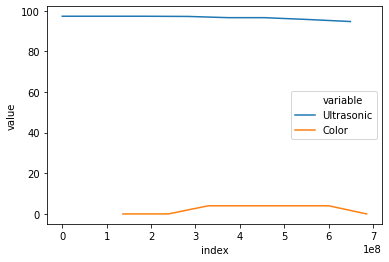

In [40]:
import seaborn as sns
ax = sns.lineplot(x="index", y="value", hue='variable', data=df)

We can also do faceted plots to better cope with different scales.

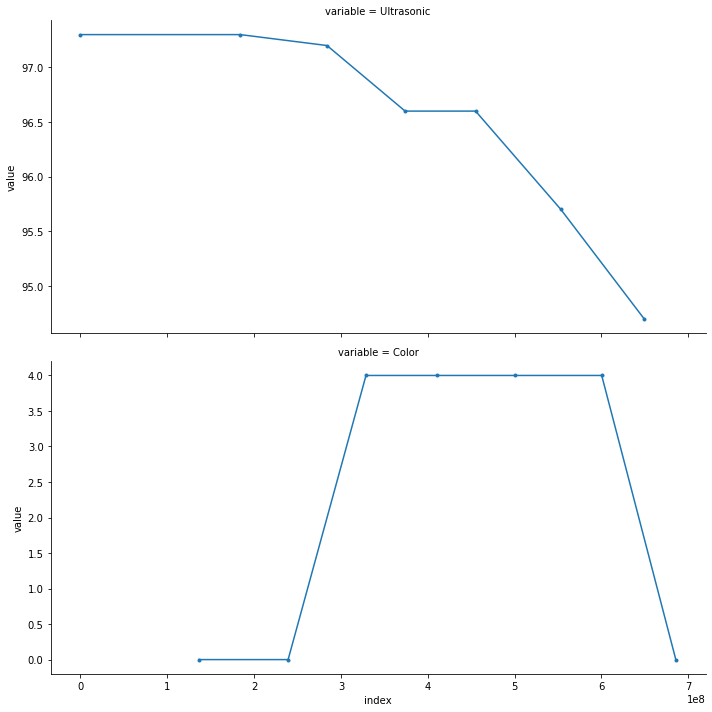

In [41]:
import matplotlib.pyplot as plt

g = sns.FacetGrid(df, row="variable", height=5, aspect=2, sharey=False)
g = g.map(plt.plot, "index", "value", marker=".");

At the moment, we can only embed a single simulator in the single notebook.

This makes it trickier to maintain separate cells for running different programs.

Also note that the code intended for execution by the simulator must be contained within a single cell.

To send code to a simulator, create the simulator:

First we need to define a `%%sim_magic` block cell magic; the magic accepts a variable referring to the simulator object as well the lines of code we want to execute:

In [42]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def sim_magic(line, cell):
    "Send code to simulator."
    eval(line).set_element("prog", cell)

Prefix the a code cell with themagic and the reference to the simulator and then run the cell.

If you now click the `Run` button in the simulator, the code you ran from the cell will run in the simulator.

In [43]:
%%sim_magic testSim
print("hello world")